In [12]:
# Cell 1: Load and split data

import pandas as pd
import numpy as np

# Load dataset and parse datetime
df = pd.read_csv("SeoulBikeDataClean.csv", parse_dates=["datetime"])

# 保留 functioning_day == 'Yes' 的记录
df = df[df['functioning_day'] == 'Yes'].copy()

# 目标变量（原始尺度）
df['target'] = df['rented_bike_count']

# 时间切分
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("✅ Data loaded and split:")
print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


✅ Data loaded and split:
Train: (7152, 37)
Val:   (665, 37)
Test:  (648, 37)


In [13]:
# Cell 2: Feature selection and preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 选用的所有特征，包括你构造的交互变量
all_features = [
    'hour', 'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2', 'rainfallmm', 'snowfall_cm',
    'seasons', 'holiday', 'weekday', 'month', 'time_bin',
    'is_raining', 'is_snowing', 'temperaturec_squared',
    'is_weekend', 'is_holiday', 'is_working_day',
    'temp_rain', 'temp_snow', 'humid_rain'
]

# 数值特征
numeric_features = [
    'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2',
    'rainfallmm', 'snowfall_cm', 'temperaturec_squared',
    'temp_rain', 'temp_snow', 'humid_rain'
]

# 分类特征（其余的）
categorical_features = list(set(all_features) - set(numeric_features))

# 构造预处理器
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 特征矩阵和目标变量
X_train = train_df[all_features]
X_val   = val_df[all_features]
X_test  = test_df[all_features]

y_train = train_df['target']
y_val   = val_df['target']
y_test  = test_df['target']

# 应用预处理
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

print("✅ Preprocessing done.")
print("X_train_proc shape:", X_train_proc.shape)


✅ Preprocessing done.
X_train_proc shape: (7152, 74)


In [14]:
# Cell 3: Sample weighting and DMatrix creation

import xgboost as xgb

# 简单规则：若 target > 1000，则权重加倍（你可以尝试调成 3、5 做 sensitivity test）
sample_weights = 1 + 2 * (y_train > 1000).astype(int)

# DMatrix with sample weights
dtrain = xgb.DMatrix(X_train_proc, label=y_train, weight=sample_weights)
dval   = xgb.DMatrix(X_val_proc, label=y_val)
dtest  = xgb.DMatrix(X_test_proc, label=y_test)

print("✅ DMatrix created with weighted training set.")
print("Sample weights summary:")
print("Min:", sample_weights.min(), "Max:", sample_weights.max(), "Mean:", sample_weights.mean())


✅ DMatrix created with weighted training set.
Sample weights summary:
Min: 1 Max: 3 Mean: 1.5441834451901566


In [15]:
# Cell 4: Train XGBoost on original scale with sample weights

params = {
    'objective': 'reg:squarederror',
    'eta': 0.05,
    'max_depth': 6,
    'eval_metric': 'rmse',
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=20
)

print("✅ Weighted model training complete.")


[0]	train-rmse:713.03867	eval-rmse:603.30433
[20]	train-rmse:378.98860	eval-rmse:402.18618
[40]	train-rmse:257.62775	eval-rmse:372.40134
[50]	train-rmse:229.11840	eval-rmse:375.45868
✅ Weighted model training complete.


📊 Test RMSE: 361.59
📊 Test R²:   0.3698


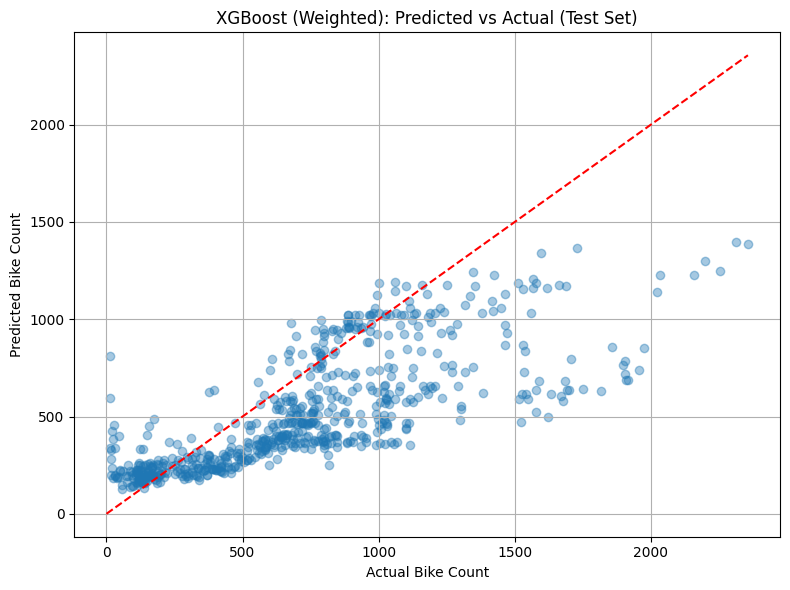

In [16]:
# Cell 5: Predict on test set and evaluate

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 预测
y_test_pred = xgb_model.predict(dtest)

# 指标评估
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print(f"📊 Test RMSE: {rmse:.2f}")
print(f"📊 Test R²:   {r2:.4f}")

# 可视化：真实 vs 预测
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.title("XGBoost (Weighted): Predicted vs Actual (Test Set)")
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.grid(True)
plt.tight_layout()
plt.show()
